In [2]:
import numpy as np
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import rivapy.marketdata as mktdata
import rivapy.models as models
#reload modules 
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
ssvi = mktdata.VolatilityParametrizationSSVI(expiries=[1.0/365, 30/365, 0.5, 2.0], fwd_atm_vols=[0.1, 0.2, 0.3, 0.4], rho=-0.5, eta=0.1, gamma=0.5)
svi = mktdata.VolatilityParametrizationSVI(expiries=np.array([1.0/365.0, 1.0]), svi_params=[
        (0.0001, 0.1, -0.5, 0.0, 0.0001),
        (0.0002, 0.1, -0.5, 0.0, 0.00004),
])

In [74]:
x_strikes = np.linspace(0.5, 1.5, 50)
time_grid = np.linspace(0.0, 2.0, 160)
lv_model = models.LocalVol(ssvi, x_strikes, time_grid, np.zeros(shape=time_grid.shape))

/home/doeltz/doeltz/development/RiVaPy/rivapy/models/__init__.py:46: RuntimeWarning: divide by zero encountered in true_divide
  p = log_x_strikes[1:-1] / tiv[:,1:-1]
/home/doeltz/doeltz/development/RiVaPy/rivapy/models/__init__.py:47: RuntimeWarning: invalid value encountered in multiply
  q = np.maximum(1 - p*dyw + 0.25*(-0.25 - 1.0 / tiv[:,1:-1] + p*p)*dyw*dyw + 0.5*dyyw, eps)
/home/doeltz/doeltz/development/RiVaPy/rivapy/models/__init__.py:47: RuntimeWarning: divide by zero encountered in true_divide
  q = np.maximum(1 - p*dyw + 0.25*(-0.25 - 1.0 / tiv[:,1:-1] + p*p)*dyw*dyw + 0.5*dyyw, eps)
/home/doeltz/doeltz/development/RiVaPy/rivapy/models/__init__.py:47: RuntimeWarning: invalid value encountered in add
  q = np.maximum(1 - p*dyw + 0.25*(-0.25 - 1.0 / tiv[:,1:-1] + p*p)*dyw*dyw + 0.5*dyyw, eps)


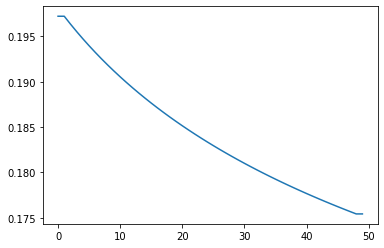

In [75]:
plt.plot(lv_model._local_variance[150,:])

In [76]:
n_sims = 100000

def apply_mc_step(ln_x0, x0, t0, t1, rnd, model):
    drift, vol = model.get_SDE_coeff(t0, x0)
    #print(vol)
    #ln_x0 += drift*(t1-t0) + vol*np.sqrt(t1-t0)*rnd
    return ln_x0 + drift*(t1-t0) + vol*np.sqrt(t1-t0)*rnd

def simulate_lv_model(x0, time_grid, lv_model, n_sims):
    ln_x = np.log(x0)*np.ones(shape=(n_sims))
    x = np.exp(ln_x)
    for i in range(1,time_grid.shape[0]):
        rnd = np.random.normal(size=(n_sims,))
        ln_x = apply_mc_step(ln_x, x, time_grid[i-1], time_grid[i], rnd, lv_model)
        x = np.exp(ln_x)
    return ln_x, x

ln_x, x = simulate_lv_model(1.0, time_grid, lv_model, n_sims)

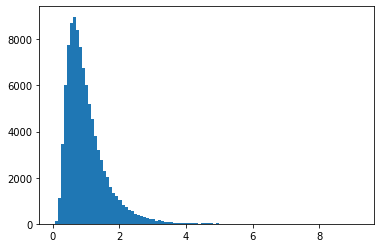

In [77]:
plt.hist(x, bins=100);

In [61]:
import math
from scipy.stats import norm
def compute_call_price_Buehler(strike:float, maturity:float, volatility:float)->float:
    """Compute a call option price for the Buehler model (w.r.t. x-process), i.e. no dividends, rates etc.
    Args:
        strike (float): strike
        maturity (float): maturity
        volatility (float): volatility

    Returns:
        float: Black-Scholes call price
    """
    sqrt_mat = math.sqrt(maturity)
    d1 = ( math.log( 1.0 / strike ) + 0.5*volatility*volatility*maturity ) / ( volatility *  sqrt_mat)
    d2 = d1 - volatility * sqrt_mat
    price =  norm.cdf(d1) - strike * norm.cdf(d2)
    return price

0.22270258921047842

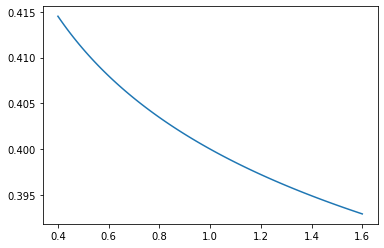

In [78]:
x_strikes = np.linspace(0.4,1.6,100)
vols = [ssvi.calc_implied_vol(2.0, x) for x in x_strikes]
plt.plot(x_strikes, vols);
compute_call_price_Buehler(1.0, maturity=2.0, volatility=ssvi.calc_implied_vol(2.0, 1.0))


In [79]:
np.mean(np.maximum(x-1.0,0))

0.2235840244114227